In [2]:
import torch
import torchvision.transforms.functional as TF
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

In [3]:
path_to_image = '/home/azureuser/Diffusion/data/cifar10-128x128/train/class2/img108.png'  # Replace with your image path

In [4]:
def image_to_tensor(image_path, size=32, device='cpu'):
    """
    Convert an image to a tensor compatible with CosineNoiseScheduler.
    
    Args:
        image_path: Path to the image file
        size: Target size (default 32 for CIFAR-10 compatibility)
        device: Device to put tensor on ('cpu' or 'cuda')
    
    Returns:
        torch.Tensor: Image tensor with shape [1, 3, H, W], values in [-1, 1]
    """
    # Load image
    img = Image.open(image_path).convert("RGB")
    
    # Resize to target size
    img = TF.resize(img, size, Image.LANCZOS)
    
    # Convert to tensor [0, 1] and add batch dimension
    tensor = TF.to_tensor(img).unsqueeze(0)  # Shape: [1, 3, H, W]
    
    # Scale to [-1, 1] for diffusion models
    tensor = tensor * 2.0 - 1.0
    
    # Move to device
    tensor = tensor.to(device)
    
    return tensor

In [5]:
class CosineNoiseScheduler:
    """
    Cosine noise scheduler that follows a cosine curve for noise addition.
    
    This scheduler adds noise more gradually at the beginning and end of the
    diffusion process, which often leads to better quality and training stability.

    At each timestep, a noise amount β(t) is defined by the schedule.

    The retention factor α(t) = 1 - β(t) represents how much signal is preserved in
    that single step (not how much of the original remains). 
    
    Alpha-bar (ᾱ) is the cumulative product of all individual alphas: ᾱ(t) = α(0) × α(1) × ... × α(t). 

    This cumulative alpha-bar tells us what percentage of the original image actually 
    remains at timestep t after all the noise additions up to that point. 

    An example of how the cumulative alpha-bar works:
    t=0: α(0)=0.99, ᾱ(0)=0.99 → 99% of original remains
    t=1: α(1)=0.98, ᾱ(1)=0.99×0.98=0.97 → 97% of original remains  
    t=2: α(2)=0.97, ᾱ(2)=0.97×0.97=0.94 → 94% of original remains
    ...
    and so on until t=1000 where ᾱ(1000)=0 (pure noise, no original content).

    """
    def __init__(self, num_timesteps: int = 1000, s: float = 0.008):
        """
        Initialize the cosine noise scheduler and various instance attributes related to the noise schedule.
        Explanation of the parameters can be found in the class docstring.
        
        Args:
            num_timesteps: Total number of diffusion steps (T) - think of this as
                           how many timesteps from image to pure noise
            s: Small offset to prevent beta from being too small at t=0

        Returns:
            None
        """
        self.num_timesteps = num_timesteps
        self.s = s
        
        # Compute the cosine schedule
        steps = torch.arange(num_timesteps + 1, dtype=torch.float32)
        alphas_cumprod = torch.cos(((steps / num_timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        
        # Store alphas_cumprod (length: num_timesteps)
        self.alphas_cumprod = alphas_cumprod[:-1]  # Remove the last element to get length num_timesteps
        
        # Create alphas_cumprod_prev by padding with 1.0 at the beginning
        alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]])
        
        # Compute individual alphas and betas
        self.alphas = self.alphas_cumprod / alphas_cumprod_prev
        self.betas = 1.0 - self.alphas
        
        # Pre-compute values for sampling
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        
        # For reverse process
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        
    def to(self, device):
        """Move scheduler tensors to device."""
        self.alphas = self.alphas.to(device)
        self.betas = self.betas.to(device)
        self.alphas_cumprod = self.alphas_cumprod.to(device)
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(device)
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(device)
        self.sqrt_recip_alphas = self.sqrt_recip_alphas.to(device)
        return self
        
    def add_noise(self, original_images, timesteps):
        """
        Add noise to images according to the schedule.
        
        Args:
            original_images: Clean images, shape (batch, channels, height, width)
            timesteps: Timesteps for each image, shape (batch,)
            
        Returns:
            noisy_images: Images with noise added
            noise: The noise that was added
        """
        # Sample noise
        noise = torch.randn_like(original_images)
        
        # Get coefficients for the timesteps
        sqrt_alphas_cumprod = self.sqrt_alphas_cumprod[timesteps]
        sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod[timesteps]
        
        # Reshape for broadcasting (batch_size, 1, 1, 1)
        sqrt_alphas_cumprod = sqrt_alphas_cumprod.view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.view(-1, 1, 1, 1)
        
        # Add noise: x_t = sqrt(alpha_cumprod) * x_0 + sqrt(1 - alpha_cumprod) * noise
        noisy_images = sqrt_alphas_cumprod * original_images + sqrt_one_minus_alphas_cumprod * noise
        
        return noisy_images, noise

In [6]:
def image_to_tensor(image_path, device='cpu'):
    """
    Convert an image to a tensor compatible with CosineNoiseScheduler.
    
    Args:
        image_path: Path to the image file
        device: Device to put tensor on ('cpu' or 'cuda')
    
    Returns:
        torch.Tensor: Image tensor with shape [1, 3, H, W], values in [-1, 1]
    """
    # Load image
    img = Image.open(image_path).convert("RGB")
    
    # Convert to tensor [0, 1] and add batch dimension
    tensor = TF.to_tensor(img).unsqueeze(0)  # Shape: [1, 3, H, W]
    
    # Scale to [-1, 1] for diffusion models
    tensor = tensor * 2.0 - 1.0
    
    # Move to device
    tensor = tensor.to(device)
    
    return tensor

def batch_images_to_tensor(image_paths, size=32, device='cpu'):
    """
    Convert multiple images to a batched tensor.
    
    Args:
        image_paths: List of image file paths
        size: Target size for all images
        device: Device to put tensor on
    
    Returns:
        torch.Tensor: Batched tensor with shape [batch_size, 3, H, W], values in [-1, 1]
    """
    tensors = []
    
    for path in image_paths:
        # Load and process each image
        img = Image.open(path).convert("RGB")
        img = TF.resize(img, size, Image.LANCZOS)
        tensor = TF.to_tensor(img) * 2.0 - 1.0  # Scale to [-1, 1]
        tensors.append(tensor)
    
    # Stack into batch
    batch_tensor = torch.stack(tensors, dim=0).to(device)
    
    return batch_tensor

def tensor_to_image(tensor, save_path=None):
    """
    Convert tensor back to PIL Image for visualization.
    
    Args:
        tensor: Image tensor with values in [-1, 1], shape [3, H, W] or [1, 3, H, W]
        save_path: Optional path to save the image
    
    Returns:
        PIL.Image: Converted image
    """
    # Remove batch dimension if present
    if tensor.dim() == 4:
        tensor = tensor.squeeze(0)
    
    # Move to CPU and convert to [0, 1]
    tensor = tensor.detach().cpu()
    tensor = (tensor.clamp(-1, 1) + 1) * 0.5
    
    # Convert to PIL Image
    img = TF.to_pil_image(tensor)
    
    if save_path:
        img.save(save_path)
    
    return img

In [7]:
def plot_image_every_100_timesteps(scheduler, image_tensor, figsize=(20, 4)):
    """
    Plot the image at every 100 timesteps to show progressive noising.
    
    Args:
        scheduler: Your CosineNoiseScheduler instance
        image_tensor: Input image tensor [1, 3, H, W]
        figsize: Figure size
    """
    # Timesteps every 100: 0, 100, 200, ..., 900
    timesteps = list(range(0, 1000, 100))
    
    fig, axes = plt.subplots(1, len(timesteps), figsize=figsize)
    fig.suptitle('Progressive Noising Every 100 Timesteps', fontsize=16, fontweight='bold')
    
    for i, t in enumerate(timesteps):
        # Add noise at timestep t
        timestep_tensor = torch.tensor([t], device=image_tensor.device)
        noisy_image, noise = scheduler.add_noise(image_tensor, timestep_tensor)
        
        # Convert to displayable format
        img = tensor_to_image(noisy_image)
        
        # Plot
        axes[i].imshow(img)
        signal_remaining = scheduler.alphas_cumprod[t].item()
        axes[i].set_title(f't={t}\n{signal_remaining:.3f}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

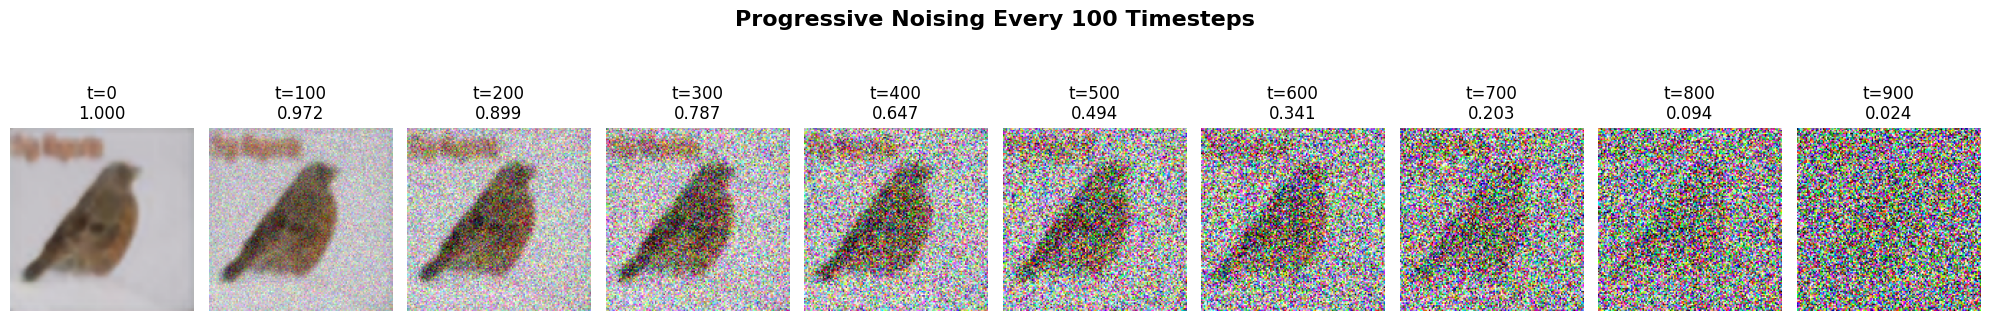

In [8]:
# Create scheduler and load image
scheduler = CosineNoiseScheduler(num_timesteps=1000, s=0.008).to('cuda')
image_tensor = image_to_tensor(path_to_image, device='cuda')

# Plot every 100 timesteps
plot_image_every_100_timesteps(scheduler, image_tensor)

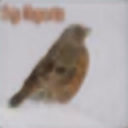

In [9]:
tensor_to_image(image_tensor)

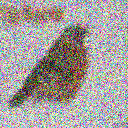

In [14]:
op = scheduler.add_noise(image_tensor, torch.tensor([300], device='cuda'))
tensor_to_image(op[0])

In [17]:
image_tensor.shape

torch.Size([1, 3, 128, 128])

In [20]:
image_tensor[0].shape

torch.Size([3, 128, 128])

In [19]:
op[0]

tensor([[[[ 0.4881,  0.4986,  0.7854,  ...,  0.2836, -0.0850,  0.7681],
          [-0.3930,  0.7338, -0.0424,  ..., -0.4416,  0.0151, -0.3370],
          [ 0.8234, -0.4239,  0.4758,  ...,  0.7383,  0.6253,  0.6284],
          ...,
          [ 1.0032,  0.3667,  0.1039,  ..., -0.3550, -0.0866,  0.2698],
          [ 0.5079,  0.5951,  1.2566,  ...,  0.7219, -0.6043, -0.1371],
          [ 0.3758,  0.5351,  0.9918,  ...,  0.1858,  0.4458, -0.1622]],

         [[ 0.1451, -0.2360,  0.4087,  ...,  0.3352,  0.1318,  0.7066],
          [ 0.4677,  0.8272,  0.5221,  ...,  0.5864,  0.4331,  0.0499],
          [ 0.9012,  0.4918,  0.7620,  ...,  0.6500,  0.9597,  0.4600],
          ...,
          [ 0.7165,  0.9338, -0.4692,  ...,  0.3779,  0.5371,  0.9112],
          [ 1.3510,  0.9208, -0.4851,  ...,  0.6067,  0.1841, -0.0071],
          [-0.0804, -0.0729,  0.5333,  ...,  0.0794, -0.3481, -0.2899]],

         [[-0.3914,  0.7735, -0.1029,  ..., -0.3326,  0.3782, -0.3380],
          [-0.2964,  1.0363,  